### 1. imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC ,
                          DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from ISLP.bart import BART

### 2. Data

In [3]:
Carseats = load_data('Carseats')
High = np.where(Carseats.Sales > 8, "Yes", "No")

### 3. 단순 나무 모형 적용

In [4]:
model = MS(Carseats.columns.drop('Sales'), intercept=False)
D = model.fit_transform(Carseats)
feature_names = list(D.columns)
X = np.asarray(D)

clf = DTC(criterion='entropy', max_depth=3, random_state=0)
# 깊이는 3으로, 손실함수는 엔트로피 이용
clf.fit(X, High)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

`-` 분류 문제에서 예측오차, 손실함수의 값, 의사결정 나무 확인

In [5]:
accuracy_score(High , clf.predict(X))

0.79

`-` Residual deviance: $ -2 \sum_m \sum_k n_{mk} \log \hat{p}_{mk} $

In [6]:
resid_dev = np.sum(log_loss(High , clf.predict_proba(X)))
resid_dev

0.4710647062649358

|--- ShelveLoc[Good] <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- weights: [7.00, 3.00] class: No
|   |   |--- Income >  57.00
|   |   |   |--- weights: [7.00, 29.00] class: Yes
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- weights: [183.00, 41.00] class: No
|   |   |--- Advertising >  13.50
|   |   |   |--- weights: [20.00, 25.00] class: Yes
|--- ShelveLoc[Good] >  0.50
|   |--- Price <= 135.00
|   |   |--- US[Yes] <= 0.50
|   |   |   |--- weights: [6.00, 11.00] class: Yes
|   |   |--- US[Yes] >  0.50
|   |   |   |--- weights: [2.00, 49.00] class: Yes
|   |--- Price >  135.00
|   |   |--- Income <= 46.00
|   |   |   |--- weights: [6.00, 0.00] class: No
|   |   |--- Income >  46.00
|   |   |   |--- weights: [5.00, 6.00] class: Yes



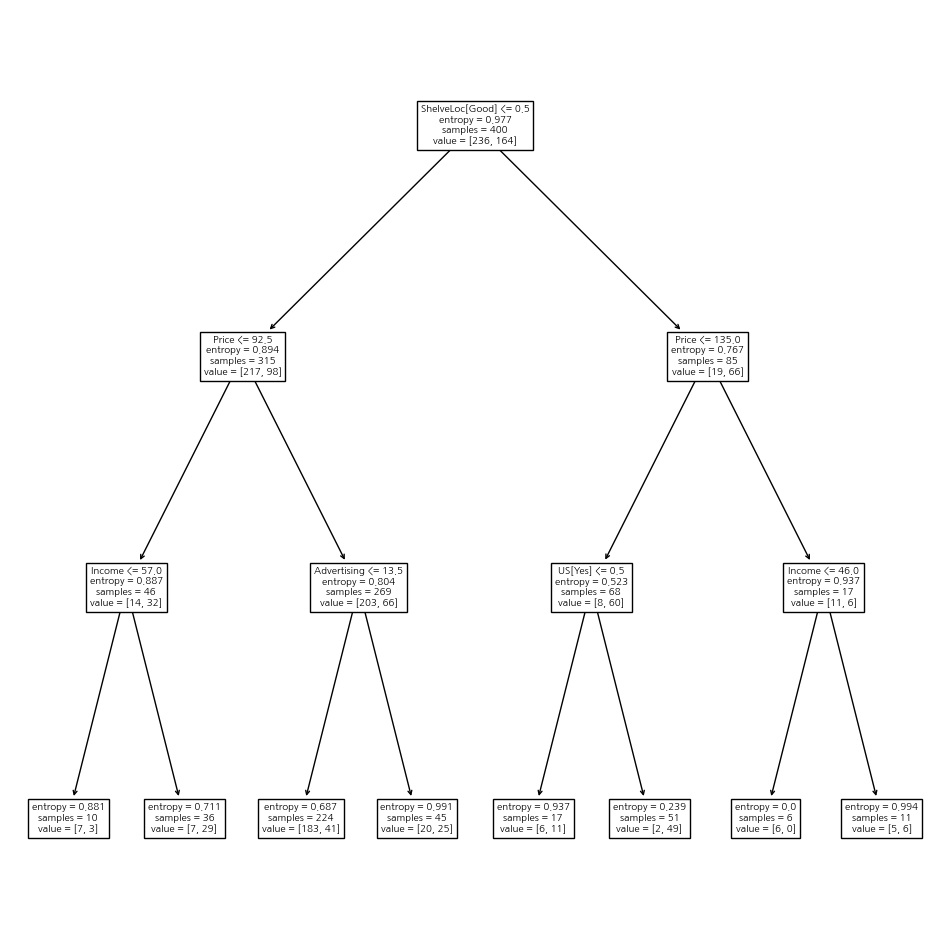

In [7]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf, feature_names=feature_names, ax=ax);
print(export_text(clf, feature_names=feature_names, show_weights=True))
# weights: 0과 1의 비중

`-` Validation error 확인

In [8]:
validation = skm.ShuffleSplit(n_splits=1, test_size=200, random_state=0)
results = skm.cross_validate(clf, D, High, cv=validation)
results['test_score']

array([0.685])

`-` 두 개의 데이터셋으로 쪼개서 훈련과 평가 진행

In [9]:
(X_train, X_test, High_train, High_test) = skm.train_test_split(X, High, test_size=0.5, random_state=0)
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, High_train)
accuracy_score(High_test, clf.predict(X_test))

0.735

`-` 훈련 데이터에서 CV로 최적의 pruning 을 선택

In [10]:
ccp_path = clf.cost_complexity_pruning_path(X_train, High_train)
kfold = skm.KFold(10, random_state=1, shuffle=True)
grid = skm.GridSearchCV(clf, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True,cv=kfold,
scoring='accuracy')
grid.fit(X_train, High_train)
grid.best_score_

0.685

`-` CV로 선택된 최적의 의사결정나무를 그림

30

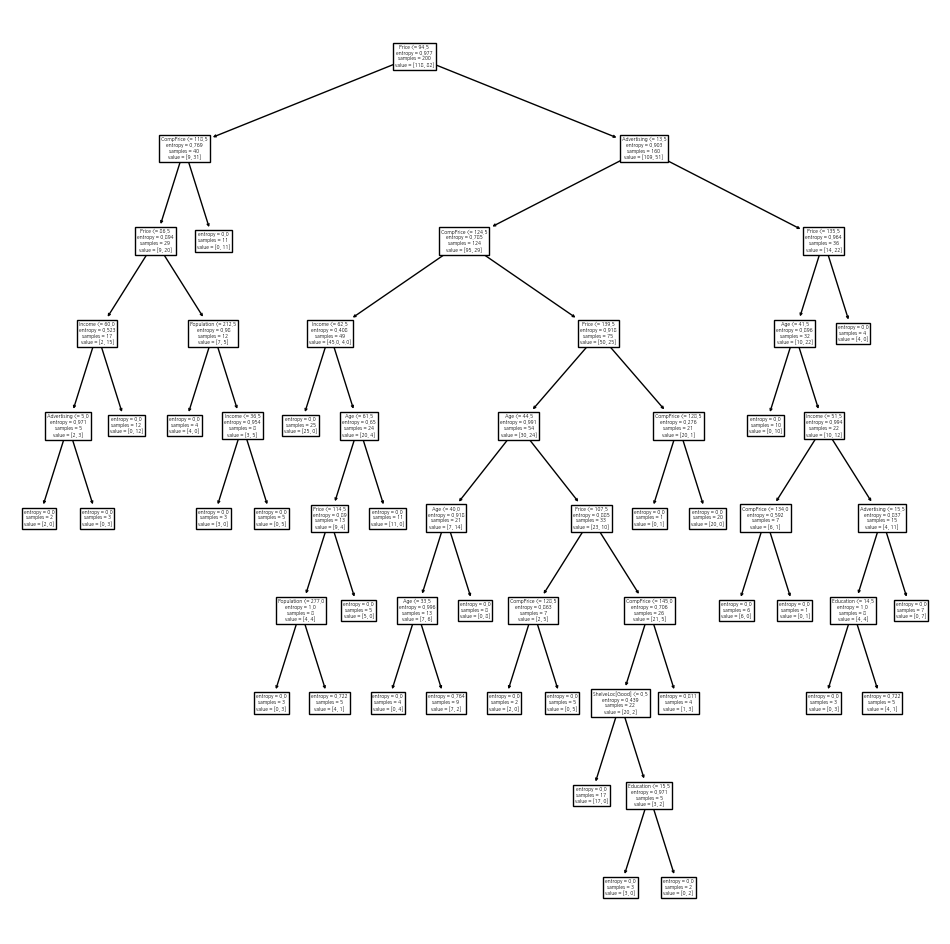

In [12]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_, feature_names=feature_names, ax=ax);
best_.tree_.n_leaves

`-` 훈련 데이터에서 모형을 구축하고 평가 데이터에서 혼동행렬을 봄

In [13]:
print(accuracy_score(High_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test), High_test)
print(confusion)

0.72
Truth      No  Yes
Predicted         
No         94   32
Yes        24   50


`-` 보스턴 데이터 로딩 및 의사결정나무(회귀분석) 분석 진행

In [14]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

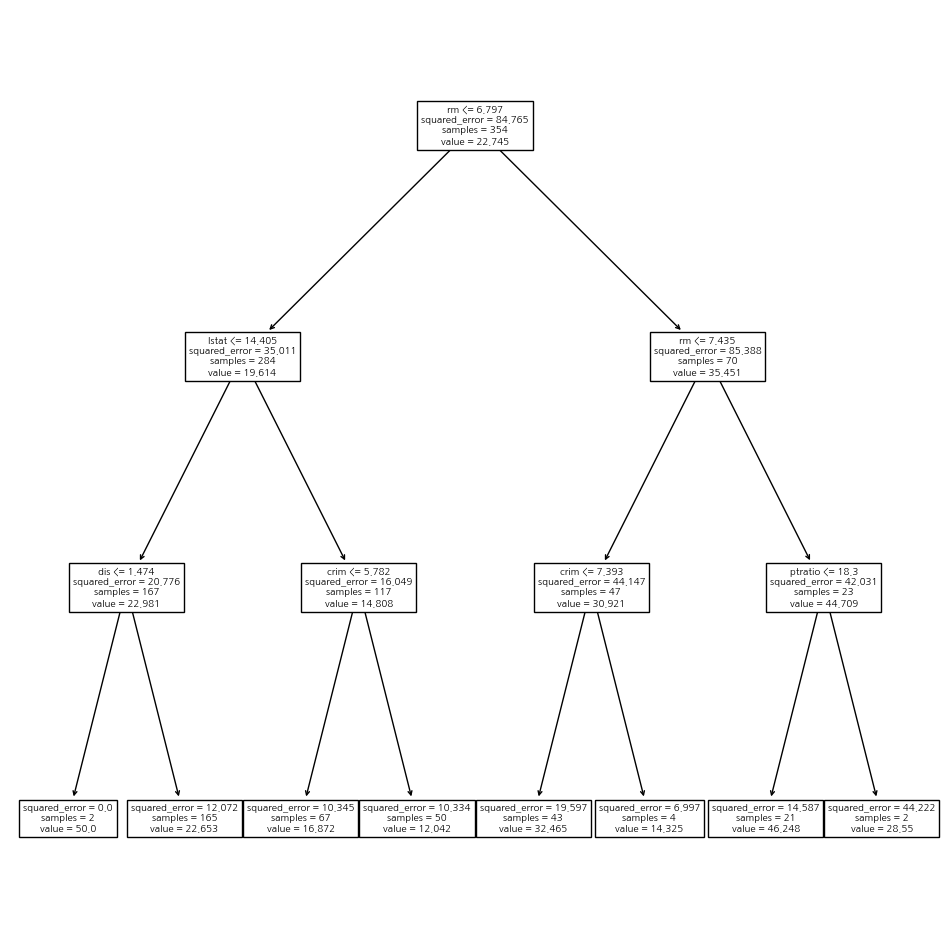

In [15]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X, Boston['medv'],test_size=0.3, random_state=0)
reg = DTR(max_depth=3)
reg.fit(X_train , y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg, feature_names=feature_names, ax=ax);

`-` CV를 통한 최적의 pruning을 진행

In [16]:
ccp_path = reg.cost_complexity_pruning_path(X_train , y_train)
kfold = skm.KFold(5, shuffle=True, random_state =10)
grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold,
       scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)

28.06985754975404

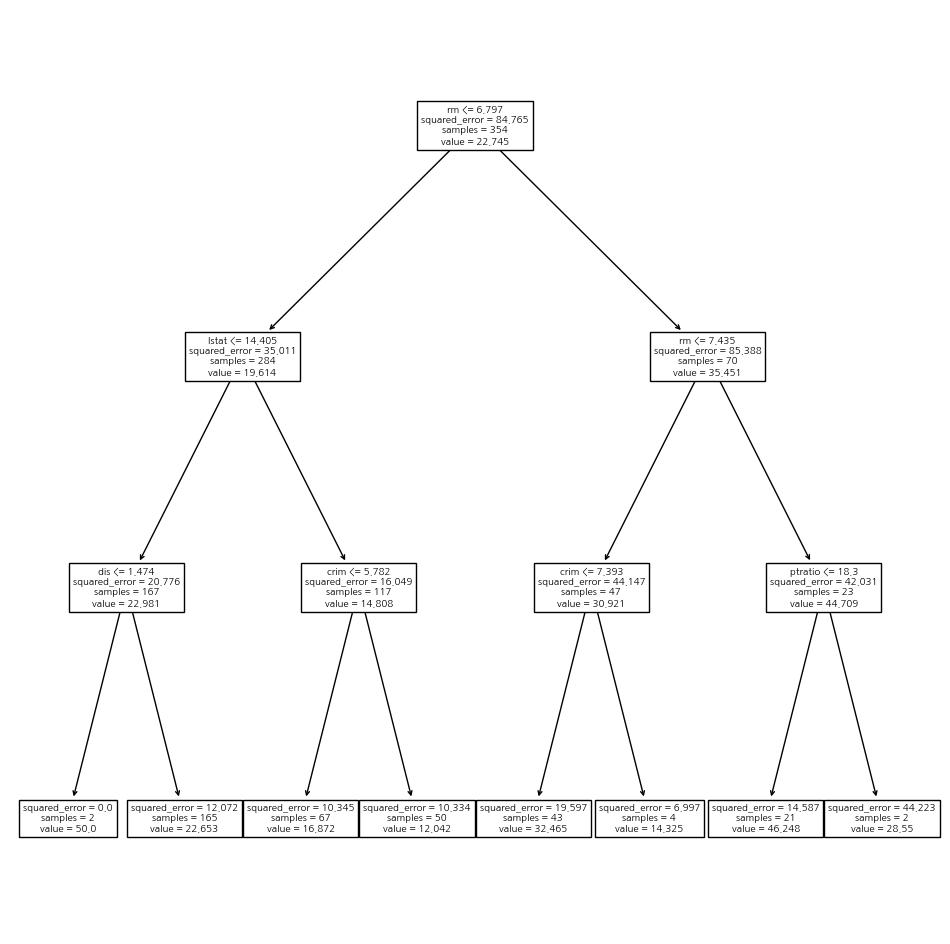

In [17]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_, feature_names=feature_names, ax=ax);

### 4. RF(Random Forests)

`-` 보스턴 데이터에 대한 랜덤 포레스트 진행

In [18]:
bag_boston = RF(max_features=X_train.shape[1], random_state=0)
bag_boston.fit(X_train , y_train)

RandomForestRegressor(max_features=12, random_state=0)

`-` 예측값과 산점도를 통해서 정확도를 확인, 예측오차를 계산

14.634700151315787

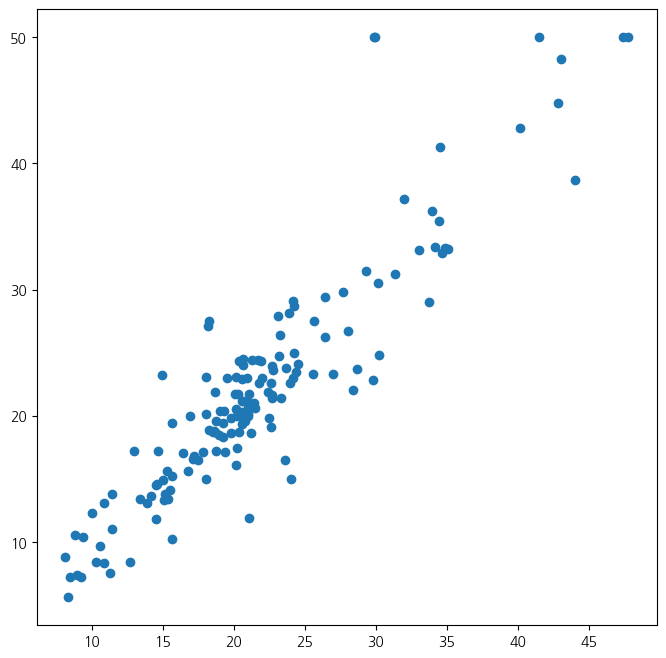

In [19]:
ax = subplots(figsize=(8,8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag , y_test)
np.mean((y_test - y_hat_bag)**2)

`-` 랜덤 포레스트에서 사용하는 변수의 개수를 조정

In [20]:
bag_boston = RF(max_features=X_train.shape[1],
n_estimators=500, random_state=0).fit(X_train , y_train)
y_hat_bag = bag_boston.predict(X_test)
print(np.mean((y_test - y_hat_bag)**2))

# usinbg sqrt(p) variables
RF_boston = RF(max_features=6, random_state=0).fit(X_train , y_train)
y_hat_RF = RF_boston.predict(X_test)
print(np.mean((y_test - y_hat_RF)**2))

14.605662565263161
20.04276446710527


`-` 변수의 중요도를 의미하는 importance를 확인

In [21]:
feature_imp = pd.DataFrame( {'importance':RF_boston.feature_importances_}, index=feature_names)
print(feature_imp.sort_values(by='importance', ascending=False))

         importance
lstat      0.356203
rm         0.332163
ptratio    0.067270
crim       0.055404
indus      0.053851
dis        0.041582
nox        0.035225
tax        0.025355
age        0.021506
rad        0.004784
chas       0.004203
zn         0.002454


`-` 그래디언트 부스팅을 진행

* 동원된 의사결정나무는 5000개, 최대 깊이는 3, 학습률은 0.001

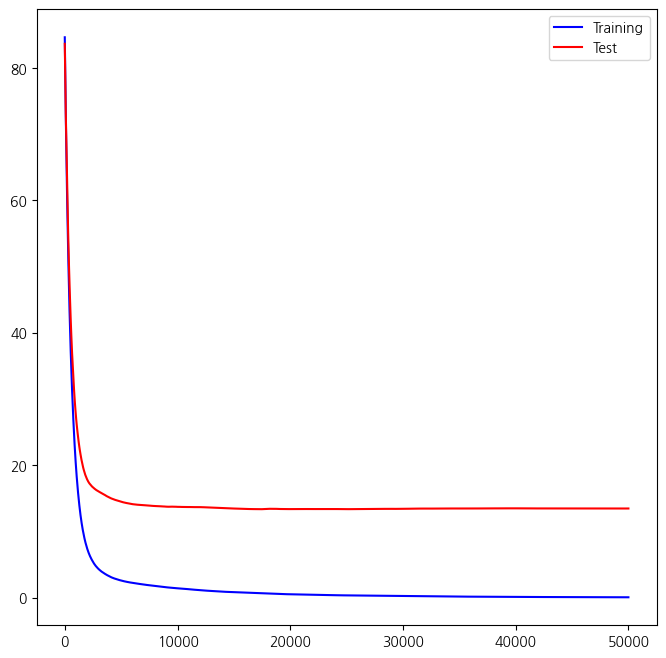

In [22]:
boost_boston = GBR(n_estimators=50000, learning_rate =0.001, max_depth=3,
random_state=0)
boost_boston.fit(X_train , y_train)

test_error = np.zeros_like(boost_boston.train_score_)
for idx , y_ in enumerate(boost_boston.staged_predict(X_test)):
  test_error[idx] = np.mean((y_test - y_)**2)
plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8,8))[1]
ax.plot(plot_idx, boost_boston.train_score_, 'b', label='Training')

ax.plot(plot_idx, test_error, 'r', label='Test')
ax.legend();

`-` 위 그림에서 단계 진행에 따른 훈련과 평가 예측오차를 확인, 아래는 예측오차 계산

In [23]:
y_hat_boost = boost_boston.predict(X_test)
np.mean((y_test - y_hat_boost)**2)

13.461677803903655

`-` 학습률 조정에 따른 예측오차

In [24]:
boost_boston = GBR(n_estimators=5000, learning_rate=0.2, max_depth=3,random_state=0)
boost_boston.fit(X_train, y_train)
y_hat_boost = boost_boston.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

14.501514553719565

### 5. 베이지안 의사결정나무

`-` 평가 데이터에서 예측오차 확인

In [25]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
# burn-in: 앞의 몇 개를 잘라냄, ndraw: 몇 개의 연쇄 샘플링을 할지 경정
bart_boston.fit(X_train , y_train)

yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test)**2)

22.145009458109225

`-` 변수의 중요도

In [26]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0), index=D.columns)
print(var_inclusion)

crim       26.933333
zn         27.866667
indus      26.466667
chas       22.466667
nox        26.600000
rm         29.800000
age        22.733333
dis        26.466667
rad        23.666667
tax        24.133333
ptratio    24.266667
lstat      31.000000
dtype: float64
